# Obtain Forecasts Using Exponential Smoothing

***

This code implements the following forecasting models:
* Single exponential smoothing (SES)
* Holt's linear trend method (double exponential smoothing - DES)
* Holt's linear trend method *with damping*
* Holt-Winters' seasonal method (triple exponential smoothing - TES)

Not implemented but may be useful:
* "Comb" - arithmetic average of forecasts from Simple, Holt's, and Damped Holt's exponential smoothing (seasonal adjustments applied to the data beforehand)

**Note**: M4 competition applied seasonal adjustments to data before applying exponential smoothing models. See [Appendix A. Supplementary Data](https://www.sciencedirect.com/science/article/pii/S0169207019301128#appSB).

***

## Steps

*For SES*
* **Step 1**: Import modules and load `Weekly` frequency `Finance` domain time series.
* **Step 2**: Apply SES to one series and examine results.
* **Step 3**: Apply SES to one series and generate rolling one-step-ahead forecasts.
* **Step 4**: Apply the code from **Step 3** to all series and compute accuracy metrics `RMSE` and `MAE`.

*For DES*
* **Step 5**: Apply **Step 4** for DES.
* **Sidebar**: Brief exploration of a case where `ExponentialSmoothing` function reports that it failed to converge. Appears to be fixed by applying a BoxCox transformation. Need to revisit this and consider conditionally applying this transformation (how do we determine a series needs this? Unstable variance?)

*For Damped DES*
* **Step 6**: Apply **Step 4** for damped DES.

*For TES*
* **Step 7**: Apply **Step 4** for TES.

*For Fun*
* **Step 8**: Compute `RMSE` and `MAE` for average of forecasts from SES, DES, damped DES, and TES.

***

## Step 1:  
Importing Modules and Loading in Data

In [1]:
# load modules
import statsmodels.tsa.holtwinters as sm
import statsmodels.tools.eval_measures as em
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import weekly finance series, skipping column names
ts = np.genfromtxt("../../../Data/Train/Clean/weekly_finance_clean.csv", delimiter = ',', skip_header = 1)

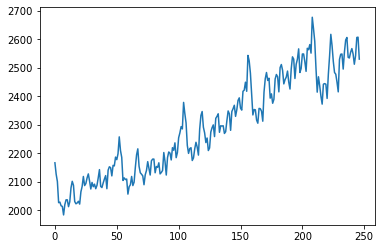

In [3]:
# plot one series
x = ts[4,:]
plt.plot(x)
plt.show()

***

## Step 2
Implement SES on one series.

See the [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing) documentation for the `ExponentialSmoothing` function.

In [4]:
# exponential smoothing function
# can be used for SES + trend/damped trend + seasonal
ES = sm.ExponentialSmoothing(endog = x,                           # time series to model
                             initialization_method = 'estimated') # method to initialize the recursions

In [5]:
ses = ES.fit()

In [6]:
ses.summary()

Dep. Variable:,endog,No. Observations:,247
Model:,ExponentialSmoothing,SSE,404164.137
Optimized:,True,AIC,1831.846
Trend:,None,BIC,1838.865
Seasonal:,None,AICC,1832.012
Seasonal Periods:,None,Date:,"Thu, 10 Feb 2022"
Box-Cox:,False,Time:,11:53:21
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9740597,alpha,True
initial_level,2164.9436,l.0,True


The fitted object has parameters $[\alpha, \beta, \gamma, \text{initial_level}, \text{initial_trend}, \phi]$.

In [7]:
ses.optimized

array([ True, False, False,  True, False, False])

***

## Step 3
Apply SES to one series and generate rolling one-step-ahead forecasts.

Construct a loop that trains a simple exponential smoothing model on `nt` time periods, then generates `nfs` rolling one-step-ahead forecasts.

In [8]:
# loop performing rolling one-step-ahead forecasts

# number of initial training observations
nt = 100
# number of forecasts to perform
nfs = 100
# empty array to store forecasted values
pred_vals = np.array([])

for i in range(nfs):
    # specify model
    ES = sm.ExponentialSmoothing(endog = ts[4, :(nt+i)],
                                 initialization_method = 'estimated')
    # fit model
    ses = ES.fit()
    # extract one-step-ahead forecast
    pred_vals = np.append(pred_vals, ses.fittedfcast[-1])

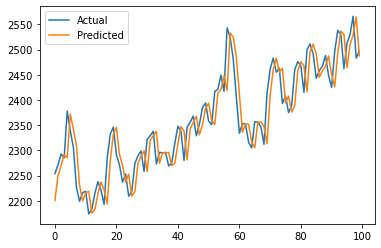

In [9]:
plt.plot(ts[4, nt:(nt+nfs)], label = "Actual")
plt.plot(pred_vals, label = "Predicted")
plt.legend()
plt.show()

***

## Step 4
Apply the code from **Step 3** to all series and compute accuracy metrics `RMSE` and `MAE`

In [10]:
# number of initial training observations
nt = 200
# number of forecasts to perform
nfs = 47
# empty array to store forecasted values
ses_pred_vals = np.zeros([ts.shape[0], nfs])

# loop through all series
for i in range(ts.shape[0]):
    if i % 10 == 0:
        print(i, 'out of', ts.shape[0], 'models trained.')
    # loop for nfs one-step-ahead forecasts
    for j in range(nfs):
        #specify model
        ES = sm.ExponentialSmoothing(endog = ts[i, :(nt+j)],
                                     initialization_method = 'estimated')
        
        # fit model
        ses = ES.fit()
        # extract one-step-ahead forecast
        ses_pred_vals[i,j] = ses.fittedfcast[-1]

0 out of 164 models trained.
10 out of 164 models trained.
20 out of 164 models trained.
30 out of 164 models trained.
40 out of 164 models trained.
50 out of 164 models trained.
60 out of 164 models trained.
70 out of 164 models trained.
80 out of 164 models trained.
90 out of 164 models trained.
100 out of 164 models trained.
110 out of 164 models trained.
120 out of 164 models trained.
130 out of 164 models trained.
140 out of 164 models trained.
150 out of 164 models trained.
160 out of 164 models trained.


In [11]:
# actual values to compare to forecasts
actual_vals = ts[:, nt:(nt+nfs)]

In [12]:
# calculate root mean squared error and mean absolute error

# empty arrays for errors
rmse = np.zeros(ts.shape[0])
mae = np.zeros(ts.shape[0])

for i in range(ts.shape[0]):
    rmse[i] = em.rmse(actual_vals[i,:], ses_pred_vals[i,:])
    mae[i] = em.meanabs(actual_vals[i,:], ses_pred_vals[i,:])

In [13]:
# average root mean squared error
np.mean(rmse)

70.13833145492825

In [14]:
# average mean absolute error
np.mean(mae)

51.213658028041706

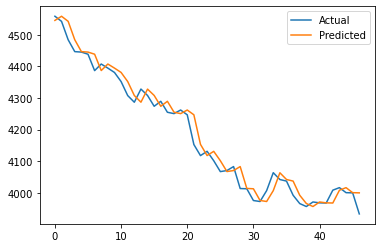

In [15]:
plt.plot(ts[10, nt:(nt+nfs)], label = "Actual")
plt.plot(ses_pred_vals[10,:], label = "Predicted")
plt.legend()
plt.show()

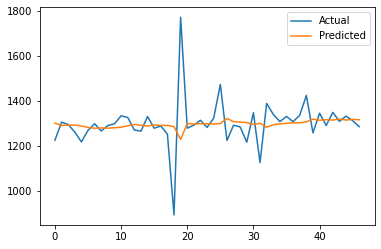

In [16]:
plt.plot(ts[150, nt:(nt+nfs)], label = "Actual")
plt.plot(ses_pred_vals[150,:], label = "Predicted")
plt.legend()
plt.show()

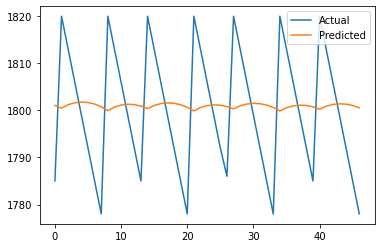

In [17]:
plt.plot(ts[160, nt:(nt+nfs)], label = "Actual")
plt.plot(ses_pred_vals[160,:], label = "Predicted")
plt.legend()
plt.show()

***

## Step 5
Apply **Step 4** for DES.

Modeling DES on all series.

In [18]:
# number of initial training observations
nt = 200
# number of forecasts to perform
nfs = 47
# empty array to store forecasted values
des_pred_vals = np.zeros([ts.shape[0], nfs])

# loop through all series
for i in range(ts.shape[0]):
    if i % 10 == 0:
        print(i, 'out of', ts.shape[0], 'models trained.')
    # loop for nfs one-step-ahead forecasts
    for j in range(nfs):
        #specify model
        ES = sm.ExponentialSmoothing(endog = ts[i, :(nt+j)],
                                     initialization_method = 'estimated',
                                     trend = 'additive',
                                     damped_trend = False)
        
        # fit model
        des = ES.fit()
        # extract one-step-ahead forecast
        des_pred_vals[i,j] = des.fittedfcast[-1]

0 out of 164 models trained.
10 out of 164 models trained.
20 out of 164 models trained.
30 out of 164 models trained.
40 out of 164 models trained.
50 out of 164 models trained.
60 out of 164 models trained.
70 out of 164 models trained.
80 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roami

90 out of 164 models trained.
100 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


110 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


120 out of 164 models trained.
130 out of 164 models trained.
140 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roami

150 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roami

160 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roami

In [19]:
# calculate root mean squared error and mean absolute error

# empty arrays for errors
rmse = np.zeros(ts.shape[0])
mae = np.zeros(ts.shape[0])

for i in range(ts.shape[0]):
    rmse[i] = em.rmse(actual_vals[i,:], des_pred_vals[i,:])
    mae[i] = em.meanabs(actual_vals[i,:], des_pred_vals[i,:])

# average root mean squared error
print(np.mean(rmse))

# average mean absolute error
print(np.mean(mae))

70.73725111627233
51.83504911968924


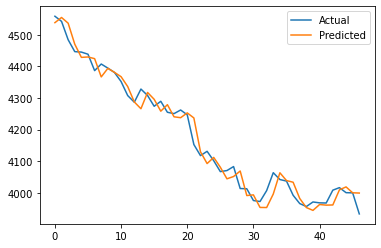

In [20]:
plt.plot(ts[10, nt:(nt+nfs)], label = "Actual")
plt.plot(des_pred_vals[10,:], label = "Predicted")
plt.legend()
plt.show()

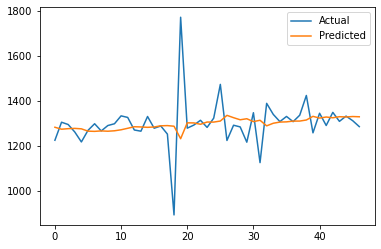

In [21]:
plt.plot(ts[150, nt:(nt+nfs)], label = "Actual")
plt.plot(des_pred_vals[150,:], label = "Predicted")
plt.legend()
plt.show()

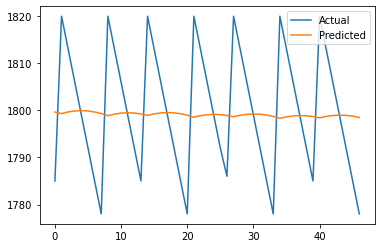

In [22]:
plt.plot(ts[160, nt:(nt+nfs)], label = "Actual")
plt.plot(des_pred_vals[160,:], label = "Predicted")
plt.legend()
plt.show()

***

### Sidebar - `'Optimization Failed to Converge'`

 We observe some instances where the model reports that the optimization failed to converge. However, I investigated this further and the model still reports `True` values for whether the parameters have been optimized, and the model generates reasonable forecasts.

See this example:

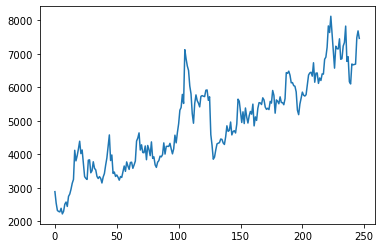

In [23]:
plt.plot(ts[85,:])
plt.show()

The model for $i = 1, \dots, 245$ used to predict $i = 246$ is reported as `failed to converge`. The forecast generated from the model still appears reasonable.

In [24]:
ES = sm.ExponentialSmoothing(endog = ts[85, :(nt+46)],
                             initialization_method = 'estimated',
                             trend = 'additive',
                             damped_trend = False)
        
# fit model
des = ES.fit()

print(des.forecast(1))
print(ts[85, nt+46])

[7639.96929713]
7465.34


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


We check the values returned from the optimization function and see `'Inequality contraints incompatible'`. We did not specify any constraints ourselves, so these must be the default ones. This issue may be resolved by pre-processing the data, which is a process I am not familiar with for forecasting (need to revisit this).

In [25]:
des.mle_retvals

     fun: 24394836.992631983
     jac: array([-3.16475000e+04, -8.60763742e+07, -6.65500000e+02, -2.40457500e+04])
 message: 'Inequality constraints incompatible'
    nfev: 5
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([ 9.00714286e-01,  1.00000000e-04,  2.53635533e+03, -1.99306061e+01])

Interestingly, the attribute indicating whether each parameter was optimized reports all parameters as optimal.

In [26]:
des.optimized

array([ True,  True, False,  True,  True, False])

The model summary reports all optimal parameters as well.

In [27]:
des.summary()

Dep. Variable:,endog,No. Observations:,246
Model:,ExponentialSmoothing,SSE,24394836.993
Optimized:,True,AIC,2838.119
Trend:,Additive,BIC,2852.141
Seasonal:,None,AICC,2838.471
Seasonal Periods:,None,Date:,"Thu, 10 Feb 2022"
Box-Cox:,False,Time:,11:56:40
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9007143,alpha,True
smoothing_trend,0.0001,beta,True


Let's look at the full forecasting process for this series.

In [28]:
pred_vals = np.zeros([nfs])
for j in range(nfs):
    ES = sm.ExponentialSmoothing(endog = ts[85, :(nt+j)],
                                 initialization_method = 'estimated',
                                 trend = 'additive',
                                 damped_trend = False)
    # fit model
    des = ES.fit()
    # extract one-step-ahead forecast
    pred_vals[j] = des.fittedfcast[-1]

C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roami

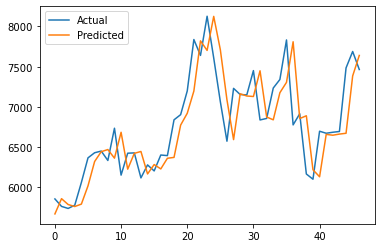

In [29]:
plt.plot(ts[85, nt:(nt+nfs)], label = "Actual")
plt.plot(pred_vals, label = "Predicted")
plt.legend()
plt.show()

We'll ignore this issue for now, and see if it still pops up after more thorough data pre-processing.

**Follow Up**: The boxcox transformation appears to resolve the optimization issue when it is present. However, applying this transformation automatically to all data creates the optimization issue for series that did not previously have problems. Need to see about conditionally applying the transformation. See the issue resolved in the two chunks below.

In [30]:
pred_vals = np.zeros([nfs])
for j in range(nfs):
    ES = sm.ExponentialSmoothing(endog = ts[85, :(nt+j)],
                                 initialization_method = 'estimated',
                                 trend = 'additive',
                                 damped_trend = False,
                                 use_boxcox = True)
    # fit model
    des = ES.fit()
    # extract one-step-ahead forecast
    pred_vals[j] = des.fittedfcast[-1]

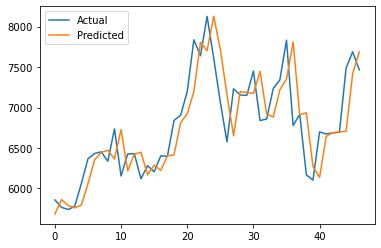

In [31]:
plt.plot(ts[85, nt:(nt+nfs)], label = "Actual")
plt.plot(pred_vals, label = "Predicted")
plt.legend()
plt.show()

***

## Step 6:
Apply **Step 4** for damped DES.

We'll go ahead and jump to the generalized modeling for all series.

In [32]:
# number of initial training observations
nt = 200
# number of forecasts to perform
nfs = 47
# empty array to store forecasted values
damped_des_pred_vals = np.zeros([ts.shape[0], nfs])

# loop through all series
for i in range(ts.shape[0]):
    if i % 10 == 0:
        print(i, 'out of', ts.shape[0], 'models trained.')
    # loop for nfs one-step-ahead forecasts
    for j in range(nfs):
        #specify model
        ES = sm.ExponentialSmoothing(endog = ts[i, :(nt+j)],
                                     initialization_method = 'estimated',
                                     trend = 'additive',
                                     damped_trend = True)
        
        # fit model
        desd = ES.fit()
        # extract one-step-ahead forecast
        damped_des_pred_vals[i,j] = desd.fittedfcast[-1]

0 out of 164 models trained.
10 out of 164 models trained.
20 out of 164 models trained.
30 out of 164 models trained.
40 out of 164 models trained.
50 out of 164 models trained.
60 out of 164 models trained.
70 out of 164 models trained.
80 out of 164 models trained.
90 out of 164 models trained.
100 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


110 out of 164 models trained.
120 out of 164 models trained.
130 out of 164 models trained.
140 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roami

C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


150 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


160 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roami

In [33]:
# calculate root mean squared error and mean absolute error

# empty arrays for errors
rmse = np.zeros(ts.shape[0])
mae = np.zeros(ts.shape[0])

for i in range(ts.shape[0]):
    rmse[i] = em.rmse(actual_vals[i,:], damped_des_pred_vals[i,:])
    mae[i] = em.meanabs(actual_vals[i,:], damped_des_pred_vals[i,:])

# average root mean squared error
print(np.mean(rmse))

# average mean absolute error
print(np.mean(mae))

70.3149625386108
51.33384585914939


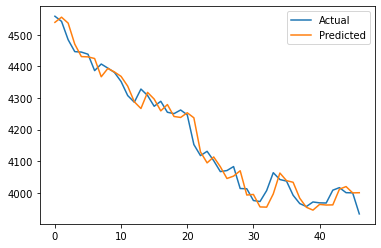

In [34]:
plt.plot(ts[10, nt:(nt+nfs)], label = "Actual")
plt.plot(damped_des_pred_vals[10,:], label = "Predicted")
plt.legend()
plt.show()

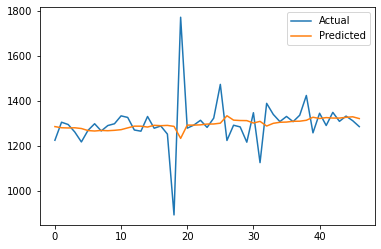

In [35]:
plt.plot(ts[150, nt:(nt+nfs)], label = "Actual")
plt.plot(damped_des_pred_vals[150,:], label = "Predicted")
plt.legend()
plt.show()

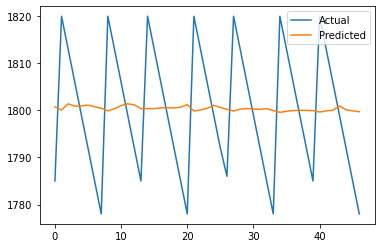

In [36]:
plt.plot(ts[160, nt:(nt+nfs)], label = "Actual")
plt.plot(damped_des_pred_vals[160,:], label = "Predicted")
plt.legend()
plt.show()

***

## Step 7:
Apply **Step 4** for TES (no damping).

[Seasonality blog post by Rob Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).

We'll try incorporating a seasonal component. This is weekly data, so we'll use $m = 52$. Let's jump straight into modeling on all series.

In [37]:
# number of initial training observations
nt = 200
# number of forecasts to perform
nfs = 47
# empty array to store forecasted values
tes_pred_vals = np.zeros([ts.shape[0], nfs])

# loop through all series
for i in range(ts.shape[0]):
    if i % 10 == 0:
        print(i, 'out of', ts.shape[0], 'models trained.')
    # loop for nfs one-step-ahead forecasts
    for j in range(nfs):
        #specify model
        ES = sm.ExponentialSmoothing(endog = ts[i, :(nt+j)],
                                     initialization_method = 'estimated',
                                     trend = 'additive',
                                     damped_trend = False,
                                     seasonal = 'additive',
                                     seasonal_periods = 52)
        
        # fit model
        desds = ES.fit()
        # extract one-step-ahead forecast
        tes_pred_vals[i,j] = desds.fittedfcast[-1]

0 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


10 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roami

20 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


30 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


40 out of 164 models trained.
50 out of 164 models trained.
60 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


70 out of 164 models trained.
80 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roami

90 out of 164 models trained.
100 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roami

110 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


120 out of 164 models trained.
130 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roami

140 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


150 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roami

C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roami

160 out of 164 models trained.


C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Cameron\AppData\Roami

In [38]:
# calculate root mean squared error and mean absolute error

# empty arrays for errors
rmse = np.zeros(ts.shape[0])
mae = np.zeros(ts.shape[0])

for i in range(ts.shape[0]):
    rmse[i] = em.rmse(actual_vals[i,:], tes_pred_vals[i,:])
    mae[i] = em.meanabs(actual_vals[i,:], tes_pred_vals[i,:])

# average root mean squared error
print(np.mean(rmse))

# average mean absolute error
print(np.mean(mae))

78.26845868477406
58.83327009863073


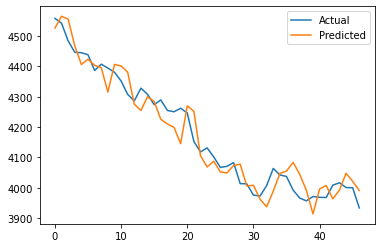

In [39]:
plt.plot(ts[10, nt:(nt+nfs)], label = "Actual")
plt.plot(tes_pred_vals[10,:], label = "Predicted")
plt.legend()
plt.show()

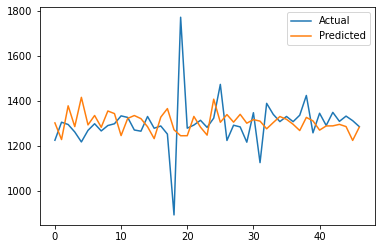

In [40]:
plt.plot(ts[150, nt:(nt+nfs)], label = "Actual")
plt.plot(tes_pred_vals[150,:], label = "Predicted")
plt.legend()
plt.show()

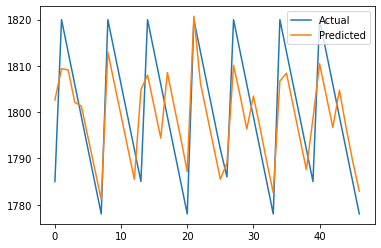

In [41]:
plt.plot(ts[160, nt:(nt+nfs)], label = "Actual")
plt.plot(tes_pred_vals[160,:], label = "Predicted")
plt.legend()
plt.show()

***

## Step 8:
Compute `RMSE` and `MAE` for average of forecasts from SES, DES, damped DES, and TES.

In [42]:
# array to store average forecasts
mean_fcasts = np.zeros([ts.shape[0], nfs])

In [43]:
# compute average forecasts
all_fcasts = np.dstack([ses_pred_vals, des_pred_vals, damped_des_pred_vals, tes_pred_vals])

In [44]:
# compute average forecasts for each series across model types
avg_all_fcasts = all_fcasts.mean(axis = 2)

In [45]:
# calculate root mean squared error and mean absolute error

# empty arrays for errors
rmse = np.zeros(ts.shape[0])
mae = np.zeros(ts.shape[0])

for i in range(ts.shape[0]):
    rmse[i] = em.rmse(actual_vals[i,:], avg_all_fcasts[i,:])
    mae[i] = em.meanabs(actual_vals[i,:], avg_all_fcasts[i,:])

# average root mean squared error
print(np.mean(rmse))

# average mean absolute error
print(np.mean(mae))

68.56902582735084
50.30536312178398


What do you know - the average forecast is better!

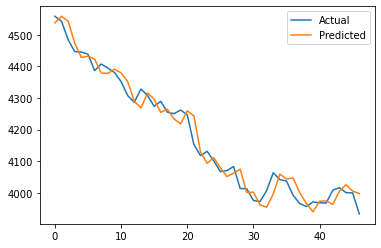

In [46]:
plt.plot(ts[10, nt:(nt+nfs)], label = "Actual")
plt.plot(avg_all_fcasts[10,:], label = "Predicted")
plt.legend()
plt.show()

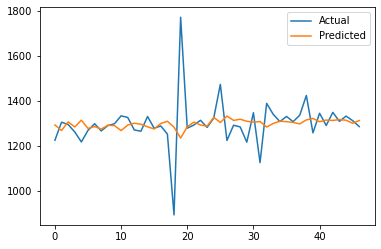

In [47]:
plt.plot(ts[150, nt:(nt+nfs)], label = "Actual")
plt.plot(avg_all_fcasts[150,:], label = "Predicted")
plt.legend()
plt.show()

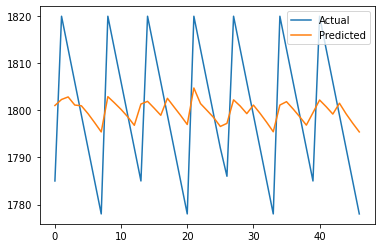

In [48]:
plt.plot(ts[160, nt:(nt+nfs)], label = "Actual")
plt.plot(avg_all_fcasts[160,:], label = "Predicted")
plt.legend()
plt.show()